In [1]:
import tensorflow as tf
from stheno.tensorflow import GP, EQ, Delta

import numpy as np
import matplotlib.pyplot as plt

In [2]:
x = tf.cast(tf.linspace(0., 2., 10), tf.float64)
y = x ** 2

length_scale = tf.Variable(tf.random.uniform((1,), dtype=tf.float64))
gp_var = tf.Variable(tf.random.uniform((1,), dtype=tf.float64))
noise_var = tf.Variable(tf.random.uniform((1,), dtype=tf.float64))

In [14]:
prior_gp =  GP(gp_var * (EQ() > length_scale)) # + noise_var * GP(Delta())
post_gp = prior_gp | (x, y)
post_gp

ValueError: TypeError: object of type 'StretchedKernel' has no len()


In [49]:
optimizer = tf.optimizers.Adam(1e-4)

In [50]:
for i in range(5):
    with tf.GradientTape() as tape:
        loss = -post_gp(x).logpdf(y)

    gradients = tape.gradient(loss, length_scale)
    optimizer.apply_gradients([(gradients, length_scale)])

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]

In [45]:
length_scale

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.9999000000025262>

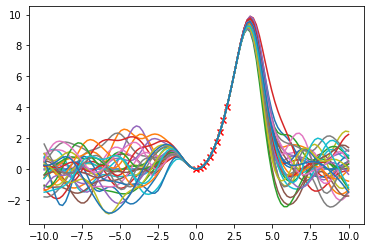

In [5]:
xs = tf.convert_to_tensor(np.linspace(-10., 10., 100), dtype=tf.float64)
y_dist = post_gp(xs)

plt.scatter(x, y, color='r', marker='x')
plt.plot(xs, y_dist.mean)

for i in range(30):
    plt.plot(xs, y_dist.sample())

plt.show()

In [6]:
post_gp(x).logpdf(y)

<tf.Tensor: id=2339, shape=(), dtype=float64, numpy=125.34122387290348>

In [3]:
from boa.models.gp_model_v2 import GPModel

gpm = GPModel(kernel="rbf",
              num_optimizer_restarts=5)

gpm | (tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]))

In [4]:
gpm.trainable_variables

[<tf.Variable 'log_length_scales_dim_0:0' shape=(1,) dtype=float64, numpy=array([0.30206447])>,
 <tf.Variable 'log_gp_variances_dim_0:0' shape=(1,) dtype=float64, numpy=array([-0.27137356])>,
 <tf.Variable 'log_noise_variance_dim_0:0' shape=(1,) dtype=float64, numpy=array([0.35886017])>]

In [5]:
gpm.train()

ValueError: No gradients provided for any variable: ['dummy_log_length_scales_dim_0:0', 'dummy_log_gp_variance_dim_0:0', 'dummy_log_noise_variance_dim_0:0'].

In [7]:
gpm.trainable_variables

[<tf.Variable 'log_length_scales_dim_0:0' shape=(1,) dtype=float64, numpy=array([-0.09727163])>,
 <tf.Variable 'log_gp_variances_dim_0:0' shape=(1,) dtype=float64, numpy=array([-0.54818152])>,
 <tf.Variable 'log_noise_variance_dim_0:0' shape=(1,) dtype=float64, numpy=array([-0.45928647])>]

In [12]:
tf.maximum([1, 2, 10, -1], 0)

<tf.Tensor: id=19, shape=(4,), dtype=int32, numpy=array([ 1,  2, 10,  0], dtype=int32)>

In [60]:
2 * GP((EQ() > tf.constant([1, 2, 3]))) + 0.5 * GP(Delta())

GP(4 * (EQ() > [1 2 3]) + 0.25 * Delta(), 0)